Fetal Health Classification

Table of Contents

**Table of contents**<a id='toc0_'></a>    
- [Introduction](#toc1_)    
- [Requirements](#toc2_)  
- [Data/Feature Preperation](#toc3_)  
- [Modeling & Classification Report](#toc4_)
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Introduction](#toc0_)
The goal is build a classification model for fetal health in order to prevent child and maternal mortality. Fetal Cardiotocograms are taken when the fetus is closer to term.
The equipment itself works by sending ultrasound pulses and reading its response, thus shedding light on fetal heart rate (FHR), fetal movements, uterine contractions and more.
The cardiotocograms are then scored by expert gynecologists, and given a score of Normal (1), Suspect (2), Pathalogical (3).\
Data Source https://www.kaggle.com/datasets/andrewmvd/fetal-health-classification


# <a id='toc2_'></a>[Requirements](#toc1_)

In [329]:
import pandas as pd
import numpy as np


%matplotlib inline
import matplotlib.pyplot as plt


from scipy import stats
from scipy.stats import norm

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter

In [330]:
fetal_health_data = pd.read_csv('fetal_health.csv')
fetal_health_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

In [331]:
fetal_health_data.shape

(2126, 22)

In [332]:

fetal_health_data.isna().sum()

baseline value                                            0
accelerations                                             0
fetal_movement                                            0
uterine_contractions                                      0
light_decelerations                                       0
severe_decelerations                                      0
prolongued_decelerations                                  0
abnormal_short_term_variability                           0
mean_value_of_short_term_variability                      0
percentage_of_time_with_abnormal_long_term_variability    0
mean_value_of_long_term_variability                       0
histogram_width                                           0
histogram_min                                             0
histogram_max                                             0
histogram_number_of_peaks                                 0
histogram_number_of_zeroes                                0
histogram_mode                          

In [333]:
fetal_health_data['fetal_health'].value_counts()

1.0    1655
2.0     295
3.0     176
Name: fetal_health, dtype: int64

In [334]:
for c in fetal_health_data.columns:
    print("Feature: ", c)
    print(fetal_health_data[c].value_counts())

Feature:  baseline value
133.0    136
130.0    111
122.0    109
138.0    103
125.0     91
128.0     85
120.0     78
142.0     77
144.0     77
132.0     76
136.0     72
140.0     70
134.0     67
135.0     65
146.0     62
127.0     60
137.0     59
129.0     57
131.0     56
143.0     56
123.0     56
148.0     52
121.0     44
139.0     39
141.0     39
126.0     38
145.0     37
115.0     28
150.0     26
110.0     21
149.0     18
119.0     17
152.0     17
112.0     16
147.0     14
151.0     14
159.0     12
114.0     11
158.0     10
124.0     10
118.0      9
154.0      8
106.0      7
116.0      5
157.0      4
156.0      4
117.0      2
160.0      1
Name: baseline value, dtype: int64
Feature:  accelerations
0.000    894
0.003    161
0.002    160
0.001    143
0.004    117
0.006    112
0.005    110
0.008    103
0.007     91
0.009     60
0.010     50
0.011     36
0.012     24
0.013     22
0.014     20
0.015      9
0.016      7
0.017      4
0.018      2
0.019      1
Name: accelerations, dtype: int6

In [335]:
fetal_health_data['fetal_health'].value_counts()


1.0    1655
2.0     295
3.0     176
Name: fetal_health, dtype: int64

In [336]:
discrete_features = ['histogram_tendency',' histogram_number_of_zeroes']
continous_features = []

"""
baseline_value, abnormal_short_term_variability, 
percentage_of_time_with_abnormal_long_term_variability,
 histogram_width, histogram_min, histogram_max, 
 histogram_number_of_peaks, histogram_number_of_zeroes, 
 histogram_mode, histogram_mean,
 histogram_median, histogram_variance, histogram_tendency
"""

'\nbaseline_value, abnormal_short_term_variability, \npercentage_of_time_with_abnormal_long_term_variability,\n histogram_width, histogram_min, histogram_max, \n histogram_number_of_peaks, histogram_number_of_zeroes, \n histogram_mode, histogram_mean,\n histogram_median, histogram_variance, histogram_tendency\n'

# <a id='toc3_'></a>[Data Preperation](#toc3_)


Balancing Data
The target feature, fetal health is heavily imbalanced, with the leaning more towards the normal value (1).  The suspect value(2) is twice the pathlogical (3).  This 
could lead to a model that misclassifies the critical pathological cases. So will balance the data first. 

# Display distribution of target feature



In [337]:
def plot_feature_dist(feature):
    plt.hist(feature, bins=3, density=True, alpha=0.6, color='b')

    mu, std = norm.fit(feature) 
    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)

    plt.plot(x, p, 'k', linewidth=2)
    title = "Distribution of Fetal Health feature"
    plt.title(title)

    plt.show()


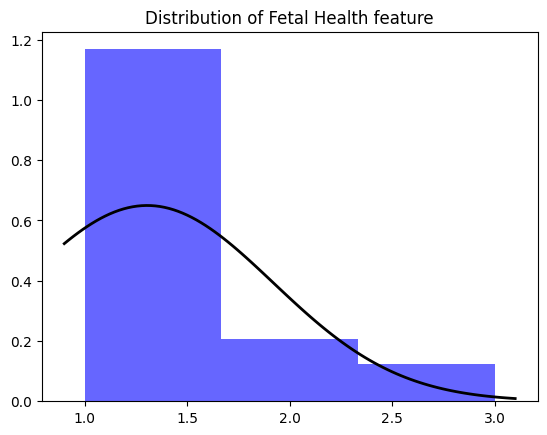

In [338]:
plot_feature_dist(fetal_health_data['fetal_health'])


#ss

In [339]:

"""x = fetal_health_data.drop('fetal_health',axis=1)
y = fetal_health_data['fetal_health']


ros = RandomOverSampler(random_state=0)
x_resampled, y_resampled = ros.fit_resample(x, y)
from collections import Counter
print(sorted(Counter(y_resampled).items()))

"""

"x = fetal_health_data.drop('fetal_health',axis=1)\ny = fetal_health_data['fetal_health']\n\n\nros = RandomOverSampler(random_state=0)\nx_resampled, y_resampled = ros.fit_resample(x, y)\nfrom collections import Counter\nprint(sorted(Counter(y_resampled).items()))\n\n"

In [340]:
#plot_feature_dist(y_resampled)

In [341]:
x = fetal_health_data.drop('fetal_health',axis=1)
y = fetal_health_data['fetal_health']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=1)

sm=SMOTE(random_state=42)
xs_train,ys_train=sm.fit_resample(x_train,y_train)
print(sorted(Counter(ys_train).items()))

[(1.0, 1329), (2.0, 1329), (3.0, 1329)]


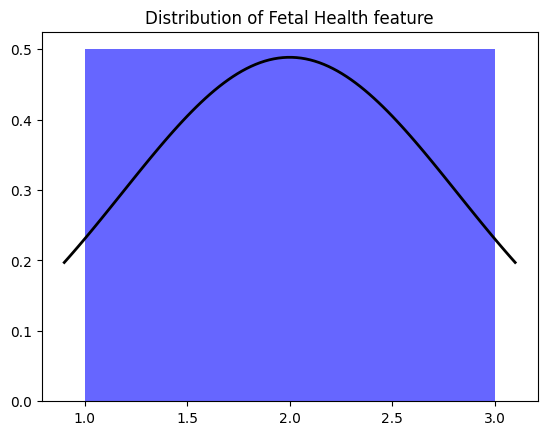

In [342]:
plot_feature_dist(ys_train)

Test the features for normality

In [343]:
for f in x.columns:
    shapiro_val = stats.shapiro(x[f])
    if(shapiro_val.pvalue > 0.05):
     print(f, " has a normal distribution, pvalue: ",shapiro_val.pvalue)
    else :(shapiro_val.pvalue < 0.05)
    print(f, " does not have a normal distribution, pvalue: ",shapiro_val.pvalue)

baseline value  does not have a normal distribution, pvalue:  2.217218195710302e-07
accelerations  does not have a normal distribution, pvalue:  2.1019476964872256e-44
fetal_movement  does not have a normal distribution, pvalue:  0.0
uterine_contractions  does not have a normal distribution, pvalue:  1.054806032324098e-24
light_decelerations  does not have a normal distribution, pvalue:  0.0
severe_decelerations  does not have a normal distribution, pvalue:  0.0
prolongued_decelerations  does not have a normal distribution, pvalue:  0.0
abnormal_short_term_variability  does not have a normal distribution, pvalue:  1.8565731594938506e-21
mean_value_of_short_term_variability  does not have a normal distribution, pvalue:  1.0772032407949676e-37
percentage_of_time_with_abnormal_long_term_variability  does not have a normal distribution, pvalue:  0.0
mean_value_of_long_term_variability  does not have a normal distribution, pvalue:  8.450860460448537e-32
histogram_width  does not have a norm

# <a id='toc4_'></a>[Modeling & Classification Report](#toc4_)

Since the predicting the fetal health based on the expert observations is a supervised classification problem, models based on the following alogorthims will be evaluated:

A. Logistic Regression
B. Random Forest
C. Support Vector Machines.

In [344]:
def model_fit(x, y, x_test, model):
    #pipe = make_pipeline(StandardScaler(), model)
    pipe = make_pipeline(MinMaxScaler(), model)
    pipe.fit(x,y)
    return pipe.predict(x_test)


In [345]:
def evaluate_model(y_predict, y_test, model, model_name):
    print("Evaluation of ", model_name, " algorithm")
    print("Accuracy is:", accuracy_score(y_test,y_predict)*100)   
    cm = confusion_matrix(y_test, y_predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_) 
    disp.plot()
    plt.show()

In [346]:
def performance_report(y_test, y_pred):
    from sklearn.metrics import classification_report
    cm_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True))
    print(cm_report)

Evaluation of  <class 'sklearn.linear_model._logistic.LogisticRegression'>  algorithm
Accuracy is: 88.49765258215963


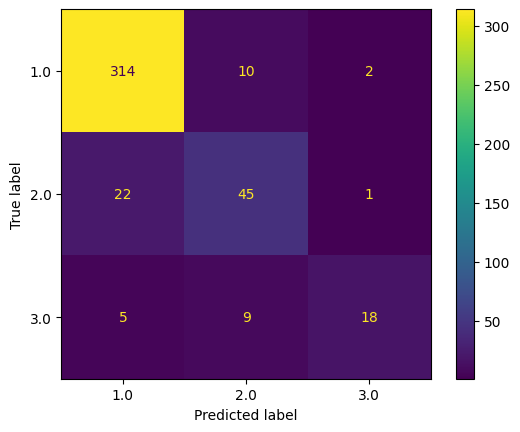

                  1.0        2.0        3.0  accuracy   macro avg  \
precision    0.920821   0.703125   0.857143  0.884977    0.827030   
recall       0.963190   0.661765   0.562500  0.884977    0.729152   
f1-score     0.941529   0.681818   0.679245  0.884977    0.767531   
support    326.000000  68.000000  32.000000  0.884977  426.000000   

           weighted avg  
precision      0.881288  
recall         0.884977  
f1-score       0.880371  
support      426.000000  
Evaluation of  <class 'sklearn.svm._classes.SVC'>  algorithm
Accuracy is: 90.84507042253522


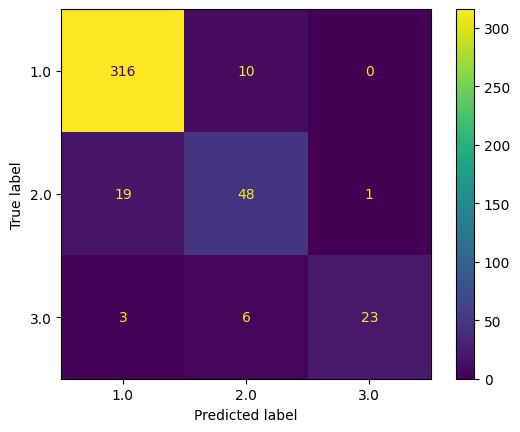

                  1.0        2.0        3.0  accuracy   macro avg  \
precision    0.934911   0.750000   0.958333  0.908451    0.881082   
recall       0.969325   0.705882   0.718750  0.908451    0.797986   
f1-score     0.951807   0.727273   0.821429  0.908451    0.833503   
support    326.000000  68.000000  32.000000  0.908451  426.000000   

           weighted avg  
precision      0.907154  
recall         0.908451  
f1-score       0.906172  
support      426.000000  
Evaluation of  <class 'sklearn.ensemble._weight_boosting.AdaBoostClassifier'>  algorithm
Accuracy is: 87.08920187793427


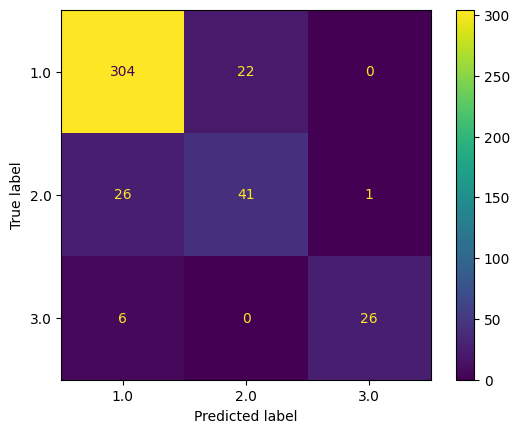

                  1.0        2.0        3.0  accuracy   macro avg  \
precision    0.904762   0.650794   0.962963  0.870892    0.839506   
recall       0.932515   0.602941   0.812500  0.870892    0.782652   
f1-score     0.918429   0.625954   0.881356  0.870892    0.808580   
support    326.000000  68.000000  32.000000  0.870892  426.000000   

           weighted avg  
precision      0.868594  
recall         0.870892  
f1-score       0.868958  
support      426.000000  
Evaluation of  <class 'sklearn.ensemble._forest.RandomForestClassifier'>  algorithm
Accuracy is: 99.76525821596243


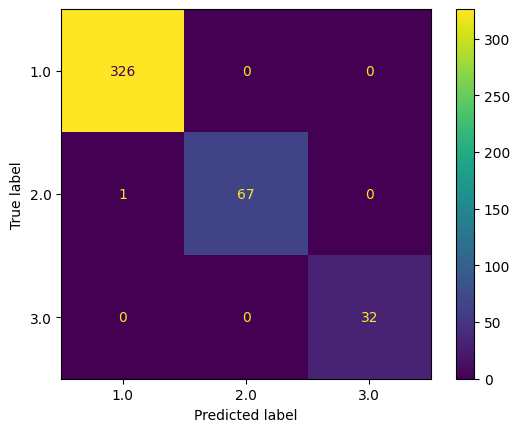

                  1.0        2.0   3.0  accuracy   macro avg  weighted avg
precision    0.996942   1.000000   1.0  0.997653    0.998981      0.997660
recall       1.000000   0.985294   1.0  0.997653    0.995098      0.997653
f1-score     0.998469   0.992593   1.0  0.997653    0.997020      0.997646
support    326.000000  68.000000  32.0  0.997653  426.000000    426.000000
Evaluation of  <class 'sklearn.naive_bayes.GaussianNB'>  algorithm
Accuracy is: 74.64788732394366


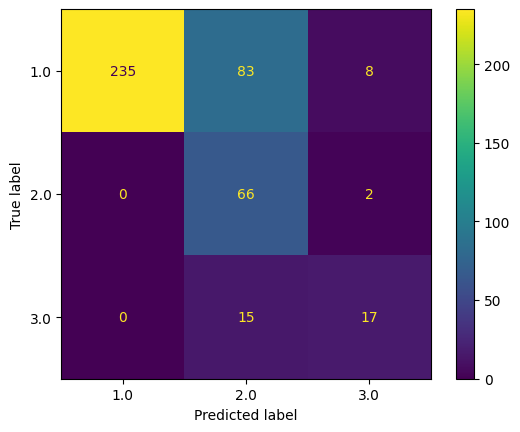

                  1.0        2.0        3.0  accuracy   macro avg  \
precision    1.000000   0.402439   0.629630  0.746479    0.677356   
recall       0.720859   0.970588   0.531250  0.746479    0.740899   
f1-score     0.837790   0.568966   0.576271  0.746479    0.661009   
support    326.000000  68.000000  32.000000  0.746479  426.000000   

           weighted avg  
precision      0.876793  
recall         0.746479  
f1-score       0.775234  
support      426.000000  


In [347]:
logistic_regression = LogisticRegression(penalty='l2', C=1, solver='newton-cg')
random_forest = RandomForestClassifier(n_estimators=100)
svclassifier = SVC(kernel='rbf')
gnb = GaussianNB()
adaBoosterDT = AdaBoostClassifier(n_estimators=100)


models = {logistic_regression, random_forest,svclassifier, gnb, adaBoosterDT}

for model in models:
    y_predict = model_fit(x, y, x_test, model)
    evaluate_model(y_predict, y_test, model, model.__class__)
    performance_report(y_test, y_predict)

# <a id='toc5_'></a>[Analysis and Conclusion](#toc5_)

The overall accuracy score is important, but the recall weighs more heavily than the precision. \
"If we optimize for recall, we will decrease the number of False Negatives".  \
("https://towardsdatascience.com/comprehensive-tutorial-on-using-confusion-matrix-in-classification-92be4d70ea18").  \
This is even more important for the 2 (Suspect), and 3 (Pathalogical) classes.
The precision is a measure of the positive prediction, and recall is a measure of the negative prediction.  \
A false positive is not as bad, as that will result in the mother and fetus recieving more attention,  \
and care unlike a false negative Pathlogical (3), where the fetus and mother could be in distress, but do not recieve care.

In light of the aforemetioned concerns, then the model developed using the ADABooster classifier would be the best
as the 0.81 recall score for the the Pathological class.  The random forest classfier model scores (class 3 recall score of 1,)  seem to indicate that the model have overfit the data, are suspect, therefore would need more test data,
or different tweaks to the data. 